# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Define path

path = '/Users/davidey/08-2023_airbnb Berlin'

In [3]:
data = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'tour_occ_nim__custom_7219257_linear.csv'), index_col = False)

### Data Source

My own dataset only covers four quarters and many values for each; it wouldn't be appropriate.

I chose the "Nights spent at tourist accommodation establishments - monthly data" as a representation of demand for tourist accomodation. It comes from Eurostat, government-collected statistics, and is thus reliable, barring user error.

I limited it to Germany only, and chose the time period of 2014-07--2023-06. The end date is the most recent available, this makes exactly 10 years, and Airbnb released an instant booking feature in 2014 (month unknown), making its user more comparable with traditional tourist accomodation establishments.

I also ensured it is giving total numbers of nights and for all kinds of accomodation available including camping grounds and trailer parks as those are also kinds of accomodation available on Airbnb. The dataset also differentiates between foreign and domestic visitors, and I limited this to the total.

https://ec.europa.eu/eurostat/databrowser/view/TOUR_OCC_NIM__custom_7219257/default/table?lang=en

https://ec.europa.eu/eurostat/cache/metadata/en/tour_occ_esms.htm

https://news.airbnb.com/instant-book-updates/#:~:text=Back%20in%202014%2C%20we%20introduced,arrival%20details%20with%20their%20host.

## Cleaning

In [4]:
data.head(5)

,DATAFLOW,LAST UPDATE,freq,c_resid,unit,nace_r2,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:TOUR_OCC_NIM(1.0),11/08/23 11:00:00,M,TOTAL,NR,I551-I553,DE,2014-07,42575471,NaN
1,ESTAT:TOUR_OCC_NIM(1.0),11/08/23 11:00:00,M,TOTAL,NR,I551-I553,DE,2014-08,48394056,NaN
2,ESTAT:TOUR_OCC_NIM(1.0),11/08/23 11:00:00,M,TOTAL,NR,I551-I553,DE,2014-09,37232561,NaN
3,ESTAT:TOUR_OCC_NIM(1.0),11/08/23 11:00:00,M,TOTAL,NR,I551-I553,DE,2014-10,34594583,NaN
4,ESTAT:TOUR_OCC_NIM(1.0),11/08/23 11:00:00,M,TOTAL,NR,I551-I553,DE,2014-11,22382570,NaN


### Subset

In [5]:
#just need time_period and value columns, which I'll rename

In [6]:
data = data[['TIME_PERIOD', 'OBS_VALUE']]

This will limit it to just the nights spent and the months, the only things I can reasonably measure here. I already limited the data in other ways (like the timeframe) in generating the data as described above.

In [7]:
data.head()

,TIME_PERIOD,OBS_VALUE
0,2014-07,42575471
1,2014-08,48394056
2,2014-09,37232561
3,2014-10,34594583
4,2014-11,22382570


In [8]:
data = data.rename(columns = {'TIME_PERIOD' : 'Date', 'OBS_VALUE' : 'Value'})

In [9]:
data.columns

Index(['Date', 'Value'], dtype='object')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    107 non-null    object
 1   Value   107 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

#Set the index as the data column.
data_2 = data.set_index("Date")
#Convert the date column/index into the date format
data_2.index = pd.to_datetime(data_2.index)
data_2.head()

,Value
Date,
2014-07-01,42575471
2014-08-01,48394056
2014-09-01,37232561
2014-10-01,34594583
2014-11-01,22382570


In [14]:
type(data_2)

pandas.core.frame.DataFrame

# 4 Line chart of data

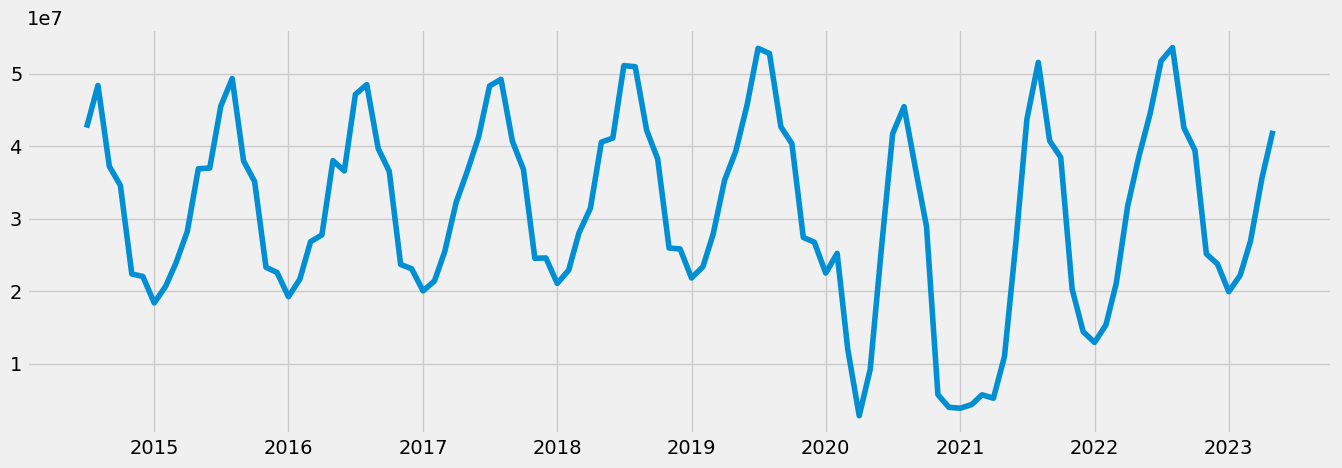

In [15]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data_2)

That looks very seasonal/cyclical all in all, quite consistent up until Feb 2020 or so when the pandemic hit, though the summer trend continued, making it a bit of noise early in 2020. Summer 2022 seems to be at about the same level as 2019.

# Wrangling, and cleaning time-series data

In [20]:
# Check for missing values (you shouldn't have any)

data_2.isnull().sum() 

Value    0
dtype: int64

In [21]:
# Check for duplicates

dups = data_2.duplicated()
dups.sum()

# No dups!

0

### 5. Time-series analysis: decomposition

I would imagine the additive model is appropriate here, given the cyclical nature it's adding/subtracting cyclically year over year.

In [24]:
# Decompose the time series using an additive model


decomposition = sm.tsa.seasonal_decompose(data_2, model='additive')

In [25]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

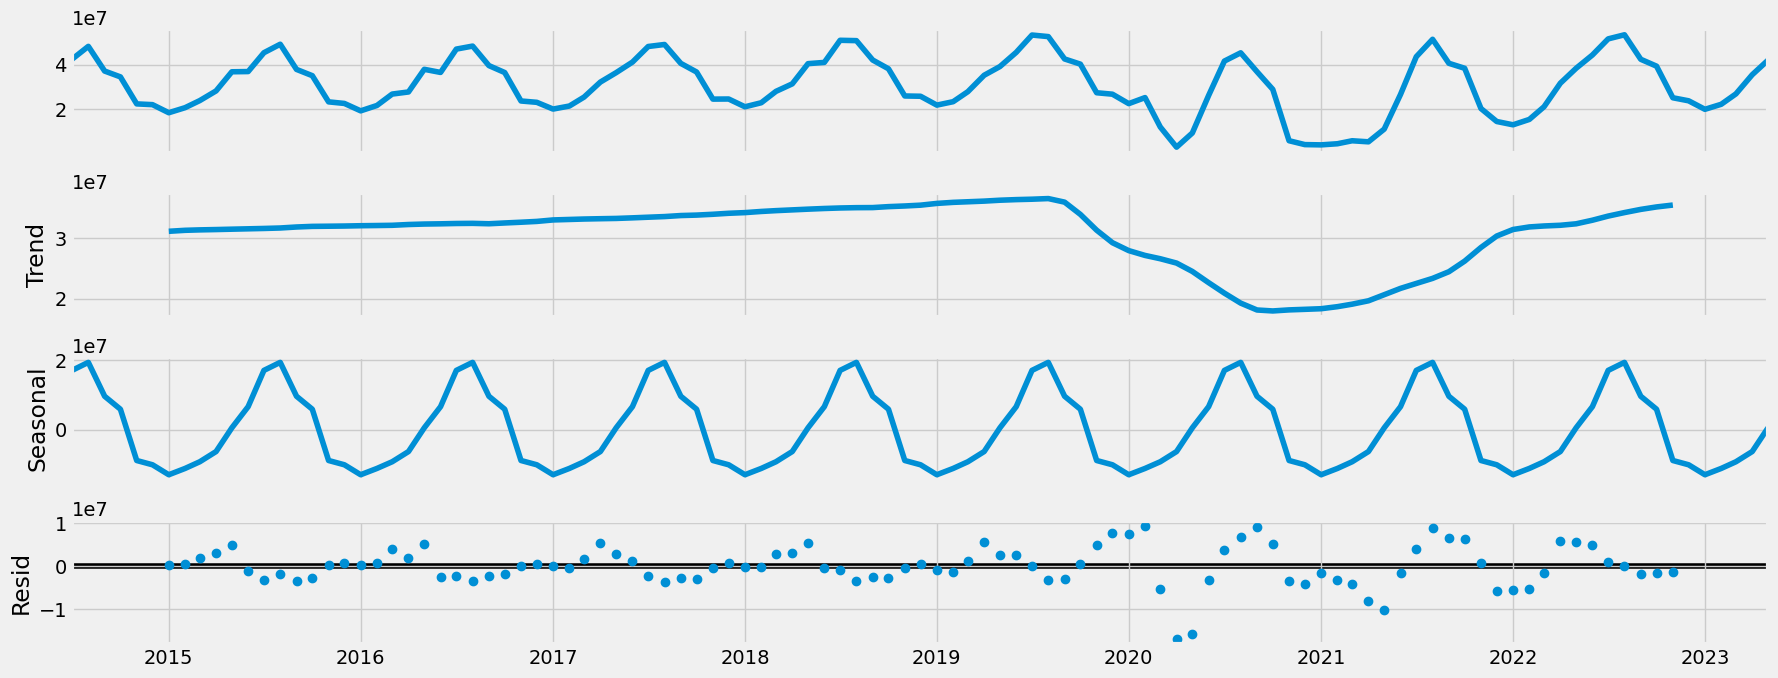

In [26]:
# Plot the separate components

decomposition.plot()
plt.show()

Yes, pandemic was basically just noise indeed.

Overall there was a slightly rising trend that was interrupted by the pandemic from 2020-22, but this has mostly recovered.

### 6. Dickey-Fuller Test

In [27]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.132407
p-value                         0.231685
Number of Lags Used            12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


The test statistic is larger than all of the critical values, so I cannot reject the null hypothesis, that there is a unit root.

Indeed, the unit root, or a non-constant jump, is the pandemic time period. This data is actually non-stationary.

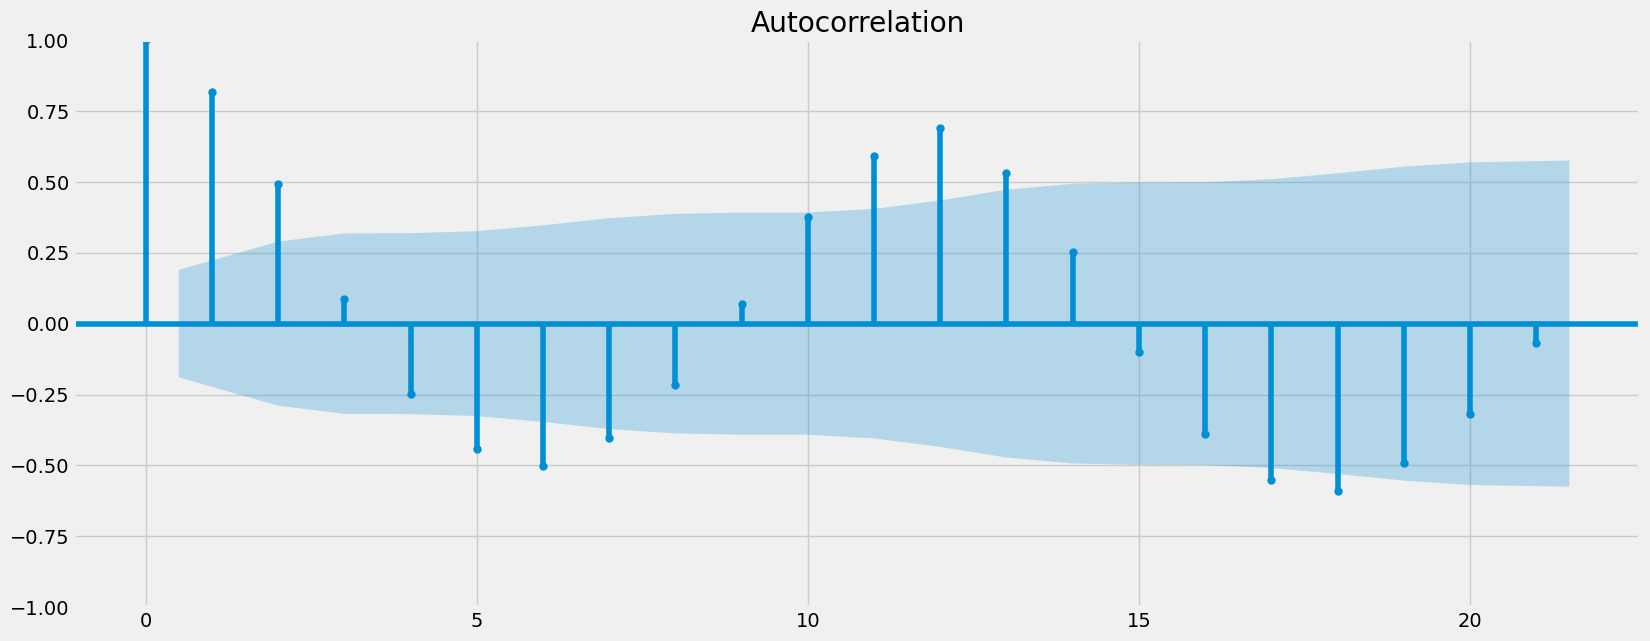

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_2)
plt.show()

I count 11 lines outside of the confidence interval and 11 lines inside. So about half of the lags are correlated with each other and this demonstrates non-stationary data.

### 7. Stationarizing the Data

In [29]:
data_diff = data_2 - data_2.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [30]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [31]:
data_diff.head()

,Value
Date,
2014-08-01,5818585.0
2014-09-01,-11161495.0
2014-10-01,-2637978.0
2014-11-01,-12212013.0
2014-12-01,-338714.0


In [32]:
data_diff.columns

Index(['Value'], dtype='object')

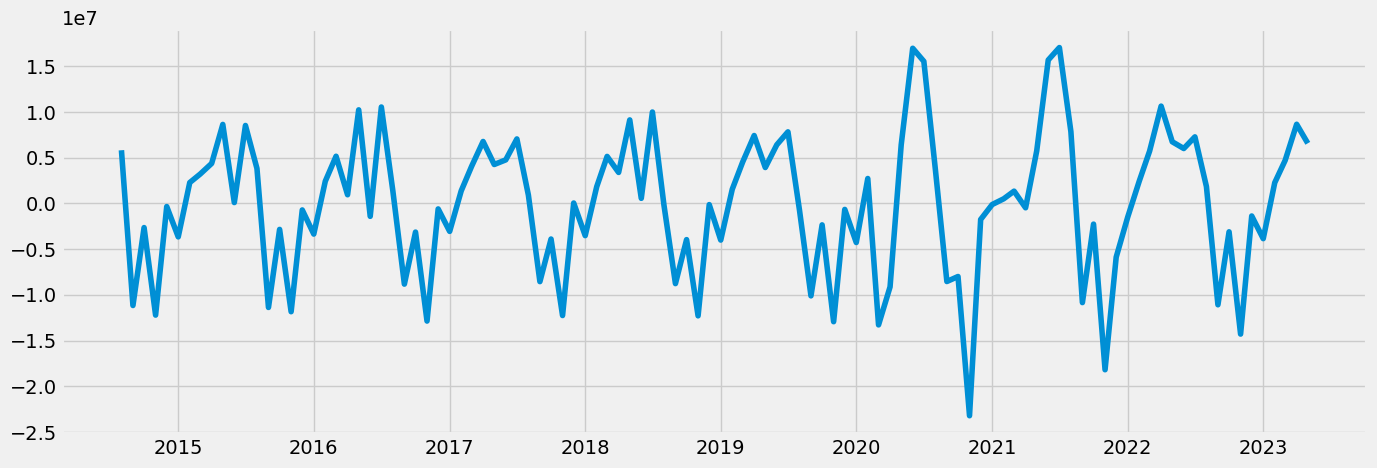

In [33]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [34]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.994110
p-value                         0.035448
Number of Lags Used            12.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


The test statistic is still greater than the critical value 1%, but lower than the others. The p-value is also lower than .05, so with this I can reject the null hypothesis and this all is now stationary!

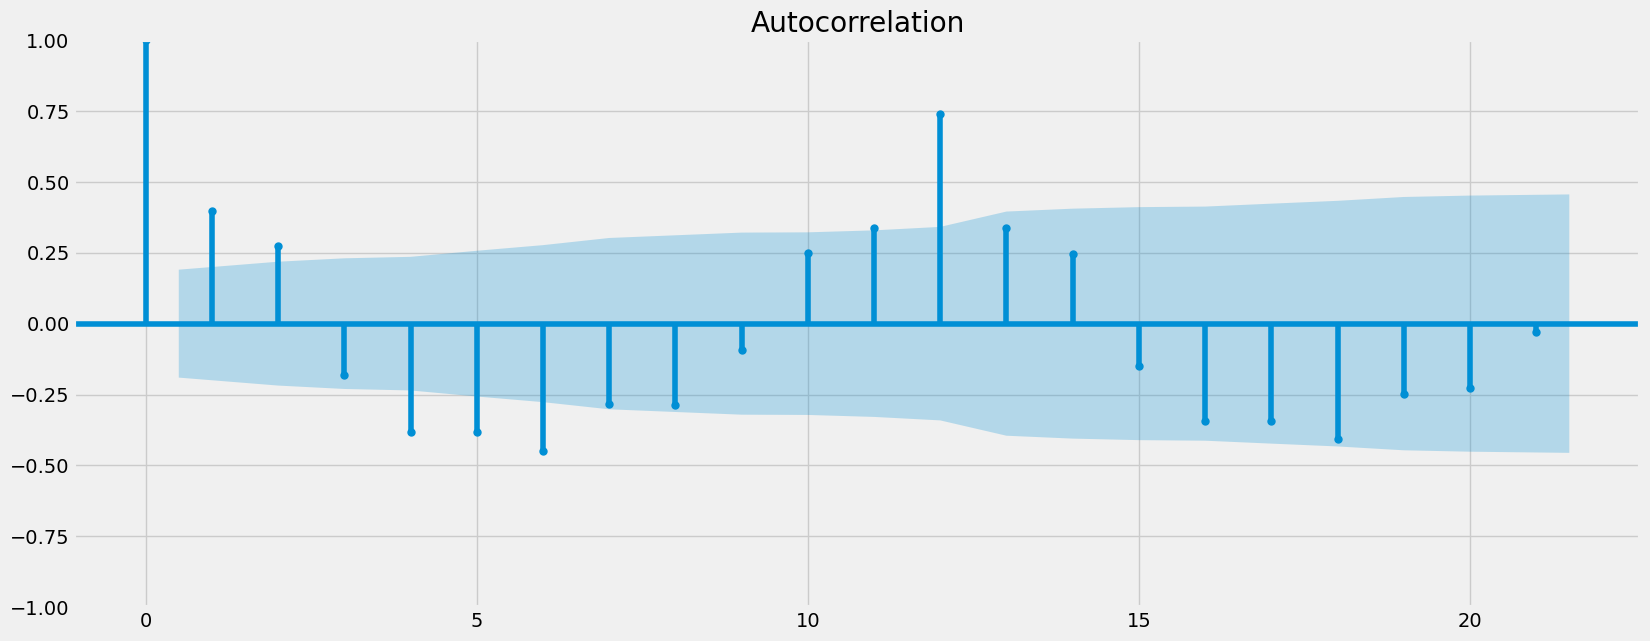

In [35]:
plot_acf(data_diff)
plt.show()

At 8 lags above the confidence interval, this is ok. It could be stationarized further, but is sufficient as it is fewer than 10 lags.